/opt/conda/envs/bees0006-rgbtseg/lib/python3.10/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
Loading config ./configs/PV1dataset/swin/../Base-PV1dataset-InstanceSegmentation.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.
Config './configs/PV1dataset/swin/CRM_swin_base_224.yaml' has no VERSION. Assuming it to be compatible with latest v2.
Global seed set to 1024
/opt/conda/envs/bees0006-rgbtseg/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bl

Now training with ./configs/PV1dataset/swin/CRM_swin_base_224.yaml...


Some model parameters or buffers are not found in the checkpoint:
network.backbone.RGB_branch.mask_token
network.backbone.RGB_branch.norm0.{bias, weight}
network.backbone.RGB_branch.norm1.{bias, weight}
network.backbone.RGB_branch.norm2.{bias, weight}
network.backbone.RGB_branch.norm3.{bias, weight}
network.backbone.THR_branch.mask_token
network.backbone.THR_branch.norm0.{bias, weight}
network.backbone.THR_branch.norm1.{bias, weight}
network.backbone.THR_branch.norm2.{bias, weight}
network.backbone.THR_branch.norm3.{bias, weight}
network.backbone.norm_layers.res2.{bias, running_mean, running_var, weight}
network.backbone.norm_layers.res3.{bias, running_mean, running_var, weight}
network.backbone.norm_layers.res4.{bias, running_mean, running_var, weight}
network.backbone.norm_layers.res5.{bias, running_mean, running_var, weight}
network.criterion.empty_weight
network.sem_seg_head.pixel_decoder.adapter_1.norm.{bias, weight}
network.sem_seg_head.pixel_decoder.adapter_1.weight
network.sem_

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


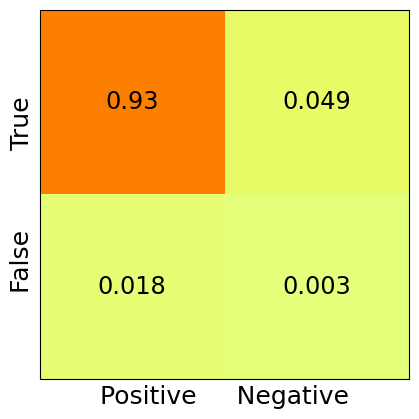

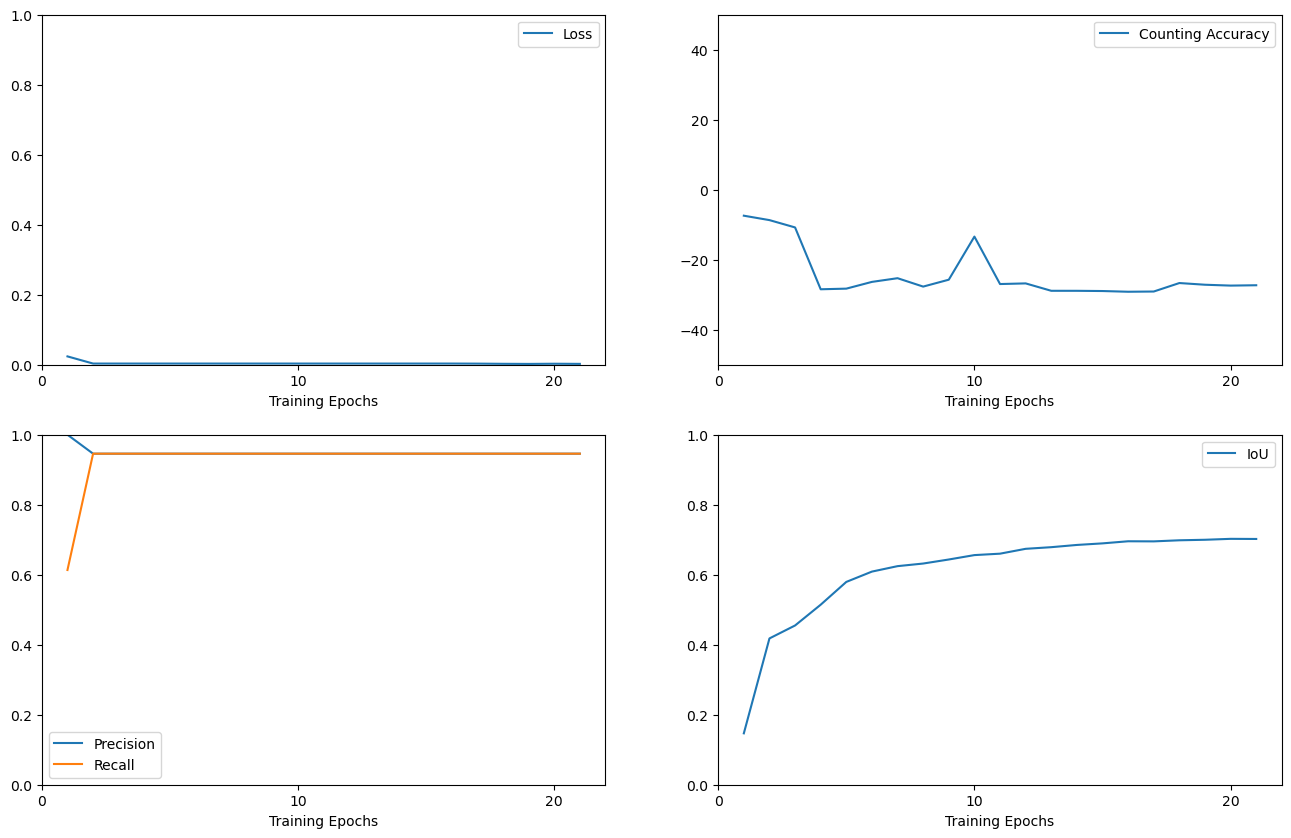

In [1]:
# Written by Ukcheol Shin, Jan. 24, 2023
# Email: shinwc159@gmail.com

import os
import os.path as osp
from mmcv import Config
import numpy as np
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint
from torch.utils.data import DataLoader
import torch
from models import MODELS
from dataloaders import build_dataset
# MaskFormer
from detectron2.config import get_cfg
from detectron2.engine import default_setup
from detectron2.projects.deeplab import add_deeplab_config
from models.mask2former import add_maskformer2_config
from models.config import add_CRM_config
from util.RGBTCheckpointer import RGBTCheckpointer
from util.util import aggregate_by_node, load_logs, training_perf, confusion_matrix
import json


class DotDict(dict):
    def __getattr__(self, attr):
        return self[attr]
    
    def __setattr__(self, attr, value):
        self[attr] = value


def my_collate_fn(batch_dict):
    return batch_dict


def setup(args):
    """
    Create configs and perform basic setups.
    """
    cfg = get_cfg()
    add_deeplab_config(cfg)
    # print(json.dumps(cfg, indent=4))
    add_maskformer2_config(cfg)
    add_CRM_config(cfg)
    cfg.merge_from_file(args.config_file)
    cfg.freeze()
    return cfg


def main(args):
    # parse args
    cfg  = setup(args)
    # Added by CINJ so this works
    torch.multiprocessing.set_sharing_strategy('file_descriptor')
    torch.set_float32_matmul_precision('high')
    
    print(f'Now training with {args.config_file}...')

    # configure seed
    seed_everything(args.seed)
    
    # prepare data loader
    dataset = build_dataset(cfg)
    train_loader = DataLoader(dataset['train'], cfg.SOLVER.IMS_PER_BATCH, shuffle=True, num_workers=cfg.DATASETS.WORKERS_PER_GPU, drop_last=True, collate_fn=my_collate_fn)
    val_loader   = DataLoader(dataset['test'], cfg.SOLVER.IMS_PER_BATCH, shuffle=False, num_workers=cfg.DATASETS.WORKERS_PER_GPU, drop_last=True, collate_fn=my_collate_fn)

    # define model
    model = MODELS.build(name=cfg.MODEL.META_ARCHITECTURE, option=cfg)
    if cfg.MODEL.META_ARCHITECTURE in {"RGBTMaskFormer"}:
        RGBTCheckpointer(model).resume_or_load(cfg.MODEL.WEIGHTS)
    if args.checkpoint:
        model.load_state_dict(torch.load(args.checkpoint)['state_dict'])

    # define trainer
    work_dir = osp.join(args.work_dir, args.name)
    checkpoint_callback = ModelCheckpoint(
                                        dirpath=work_dir,
                                        save_weights_only=False,
                                        monitor='train/total_loss',
                                        mode='min',
                                        save_top_k=1,
                                        filename='checkpoint_{epoch:02d}_{step}',
                                        every_n_epochs=1
                                        )

    trainer = Trainer(strategy='ddp' if args.num_gpus > 1 else None,
                      default_root_dir=work_dir,
                      gpus=args.num_gpus,
                      num_nodes=1,
                      max_epochs=cfg.SOLVER.MAX_ITER,
                      # max_steps=cfg.SOLVER.MAX_ITER,
                      callbacks=[checkpoint_callback],
                      check_val_every_n_epoch=1)
                      # precision=16)

    # training
    trainer.fit(model, train_loader, val_loader)
    logs = load_logs(cfg.SAVE.DIR_ROOT)
    iou = np.array(aggregate_by_node("iou", logs))
    precision = np.array(aggregate_by_node("precision", logs))
    recall = np.array(aggregate_by_node("recall", logs))
    loss = np.array(aggregate_by_node("loss", logs))
    tp = np.array(aggregate_by_node("tp", logs))
    tn = np.array(aggregate_by_node("tn", logs))
    fp = np.array(aggregate_by_node("fp", logs))
    fn = np.array(aggregate_by_node("fn", logs))
    ca = np.array(aggregate_by_node("ca", logs))
    confusion_matrix([[np.mean(tp), np.mean(fp)],[np.mean(fn), np.mean(tn)]])
    training_perf(loss, precision, recall, iou, ca)


my_args: DotDict = DotDict()
my_args.config_file = "./configs/PV1dataset/swin/CRM_swin_base_224.yaml"
my_args.seed = 1024
my_args.num_gpus = 1
my_args.work_dir = "./checkpoints"
my_args.name = "penguins_v1"
my_args.checkpoint = None  # "./checkpoints/penguins_v1/saved_checkpoint.ckpt"
os.environ["CUDA_VISIBLE_DEVICES"]="0"
main(my_args)